<a href="https://colab.research.google.com/github/Slautin/2025_Co-navigation_CrTaWV-Mo/blob/main/2025_Conavigation_kMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install botorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import tensor as tt
from itertools import product

from gpytorch.priors import GammaPrior, SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms import Normalize, Standardize
from botorch.acquisition.analytic import LogExpectedImprovement, ExpectedImprovement, UpperConfidenceBound


In [3]:
# pip install imageio pillow
import imageio.v3 as iio
from PIL import Image
import tempfile

def figures_to_gif(figs, filename="animation.gif", duration=5, size=None, dpi=150):
    """
    Convert a list of matplotlib Figure objects to a GIF.
    All frames will be resized to the same size if necessary.
    """
    tmp = tempfile.TemporaryDirectory()
    paths = []
    for i, fig in enumerate(figs):
        path = f"{tmp.name}/frame_{i:03d}.png"
        fig.savefig(path, dpi=dpi, bbox_inches="tight")
        paths.append(path)

    # Read all frames and make sure they have the same size
    images = [Image.open(p) for p in paths]
    if size is None:
        # Use the size of the first frame as reference
        size = images[0].size
    images = [im.resize(size, Image.Resampling.LANCZOS) for im in images]

    # Convert to numpy arrays and write GIF
    iio.imwrite(filename, [np.array(im) for im in images], duration=duration, loop=0)
    print(f"GIF saved to {filename}")

In [4]:
#@title functions for saving data
import h5py

def convert_to_supported_dtype(arr):
    # Check if array has an object dtype
    if arr.dtype == np.dtype('O'):
        # Attempt conversion to a compatible type (if possible)
        try:
            return arr.astype(np.float64)  # Change to a compatible type (e.g., float)
        except ValueError:
            raise ValueError(f"Cannot convert array '{arr}' to a supported dtype.")
    return arr

def save_dict_to_hdf5(file_path, data_dict):
    def save_data(group, data):
        for key, value in data.items():
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                save_data(subgroup, value)
            elif isinstance(value, np.ndarray):
                # Check and convert object dtype arrays if needed
                value = convert_to_supported_dtype(value)
                group.create_dataset(key, data=value)
            elif isinstance(value, torch.Tensor):
                # Check and convert object dtype arrays if needed
                value = convert_to_supported_dtype(value.detach().numpy())
                group.create_dataset(str(key), data=value)
            elif isinstance(value, int):
              value = np.array([value, ])
              value = convert_to_supported_dtype(value)
              group.create_dataset(key, data=value)
            else:
                group.create_dataset(key, data=value)
    with h5py.File(file_path, 'w') as f:
        save_data(f, data_dict)

def load_hdf5_to_dict(file_path):
    def load_data(group):
        data = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                data[key] = load_data(item)
            else:
                data[key] = np.array(item)
        return data

    with h5py.File(file_path, 'r') as f:
        data_dict = load_data(f)

    return data_dict

# kMC functions

In [5]:
def hex_lattice(nx=10, ny=5, a=1.0):
    """
    Generate coordinates of a 2D hexagonal (triangular) lattice.

    n: number of points along each index direction
    a: lattice constant (spacing)
    """

    coords = np.zeros((ny,nx,2))
    dy = np.sqrt(3)/2 * a
    for j in range(ny):
        y = j * dy
        x_shift = (j % 2) * (a/2)   # shift odd rows
        for i in range(nx):
            x = i * a + x_shift
            coords[j,i] = np.array([x, y])
            # coords_ij.append((j,i))
    return np.array(coords)


def hex_neighbors(i, j, max_bound = None):
    """
    Get the 6 nearest neighbors of a site (i, j) in a hexagonal (triangular) lattice
    represented as staggered rows.

    Parameters
    ----------
    i, j : int
        Lattice indices of the node (column, row).

    periodic : bool, default False
        If True, apply periodic boundary conditions. If False, neighbors
        outside the [0, nx), [0, ny) region are excluded.

    Returns
    -------
    neighbors : list of (int, int)
        List of 6 neighbor indices.
    """
    # Row parity (even or odd)
    if i % 2 == 1:  # even row
        neigh = [(i-1, j), (i+1, j),
                 (i, j-1), (i+1, j+1),
                 (i, j+1), (i-1, j+1)]
    else:  # odd row
        neigh = [(i-1, j), (i+1, j),
                 (i, j-1), (i+1, j-1),
                 (i, j+1), (i-1, j-1)]

    valid = []
    for ni, nj in neigh:
        # Always check non-negativity
        if ni < 0 or nj < 0:
            continue
        # Check boundaries if provided
        if max_bound is not None:
            nx, ny = max_bound
            if ni >= nx or nj >= ny:
                continue
        valid.append((ni, nj))

    return np.array(valid).astype(int)

def particle_generator(atoms, probs):
  while True:
    yield np.random.choice(atoms, p=probs)

def first_false_indices(arr: np.ndarray) -> np.ndarray:
    """
    Return an array of shape (k, 2) with (i, j) for columns that contain at least one False,
    where i is the minimal row index with arr[i, j] == False.
    """
    # Find rows that contain at least one False
    #false_mask = ~arr
    has_false = (arr == 0).any(axis=0)
    js = np.nonzero(has_false)[0]
    is_ = np.argmin(arr[:, js], axis=0)
    return np.column_stack((is_, js))

def surface_roughness(image_2d, norm_coef=1):
    """
    Compute RMS roughness of a 2D array.
    """
    mean_val = np.mean(image_2d)
    rms = np.sqrt(np.mean((image_2d - mean_val) ** 2))
    return rms*norm_coef

def hop_rate(E_diff, nu0, T):
    """
    Computes the physical diffusion hop rate for kMC.

    Parameters:
        Ediff
        EAB  : bond energy for A-B (eV)
        nu0  : attempt frequency (Hz), typically 1e12–1e13
        T    : temperature (K)

    Returns:
        rate : physical transition rate (1/s)
    """
    kB = 8.617333262e-5  # Boltzmann constant in eV/K

    # broken-bond diffusion barrier

    # Arrhenius rate
    rate = nu0 * np.exp( -E_diff / (kB * T) )

    return rate

def sputtering(
    film,
    dE,
    atoms,
    flow,
    t,
    n_hops = 3,
    dist = 2,
    E0=.2,
    k_up = 0.02,
    k_down = .1,
    T=700

):
  rng = np.random.default_rng()
  film_r = film.copy()

  atom_types = {}
  for i, a in enumerate(atoms):
    atom_types[int(i+1)] = a

  flow = np.full(len(atom_types), flow)
  sputtered_particles = int(np.sum(flow)*t)

  # Normalize flow to make it a probability distribution
  prob = flow / flow.sum()
  atom_count = np.arange(len(atom_types))+1
  # Draw samples with probabilities `prob`
  particle_flow = np.random.choice(atom_count, size=sputtered_particles, replace=True, p=prob)

  dE_sorted = {tuple(sorted(k)): v for k, v in dE.items()}

  for p in particle_flow:
    surf_indexes = first_false_indices(film_r)
    idx = rng.integers(len(surf_indexes))
    loc = surf_indexes[idx]
    for _ in range(n_hops):
      if loc[0] == 0:
        pass
      else:
        rates = np.array([])
        distance = np.linalg.norm(surf_indexes[:,1].reshape(1,-1) - loc[1], axis=0)
        neighb_surf = surf_indexes[(distance<dist)]
        for n_loc in neighb_surf:
          dh = n_loc[0] - loc[0]
          if dh > 0:
            es = k_up*dh
          else:
            es = k_down
          neighbours = hex_neighbors(*n_loc, max_bound=film_r.shape)
          n_atoms = film_r[neighbours[:, 0], neighbours[:, 1]]
          unique_neighbours, counts = np.unique(n_atoms, return_counts=True)
          Ediff = E0 + np.sign(dh)*es
          for u, c in zip(unique_neighbours, counts):
              if u != 0:
                key_Ea = tuple(sorted((atom_types[u],atom_types[p])))
                Ea_up = dE_sorted[key_Ea]
                Ediff += Ea_up*c
          #print('Ed ', Ediff)
          rr = hop_rate(Ediff, 1, T)
          #print(rr)
          rates = np.append(rates, rr)
        prob_hop = rates/np.sum(rates)
        event = np.random.choice(np.arange(len(neighb_surf)), p=prob_hop)
        loc = neighb_surf[event]
    film_r[*loc]=p
  return film_r

# Experimental measurement: simulation

In [6]:
!gdown https://drive.google.com/file/d/1SjNbzmHefx1Wa9W_2MbidDnx7TFdMYB7/view?usp=drive_link --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1SjNbzmHefx1Wa9W_2MbidDnx7TFdMYB7
From (redirected): https://drive.google.com/uc?id=1SjNbzmHefx1Wa9W_2MbidDnx7TFdMYB7&confirm=t&uuid=648874a8-9c14-4dd1-8c17-2716b9a148fa
To: /content/CTWWV-Mo_min.npz
100% 102M/102M [00:01<00:00, 85.8MB/s] 


In [8]:
data = np.load("/content/CTWWV-Mo_min.npz")
data_dict = {key: data[key] for key in data.files}

In [9]:
roughness_array = []
for key in data_dict:
  r = surface_roughness(data_dict[key])
  roughness_array.append([float(key), r*1e9])

roughness_array = np.array(roughness_array)

roughness_array[:,0] = 1 - (roughness_array[:,0] -  np.min(roughness_array[:,0]))/ np.ptp(roughness_array[:,0])

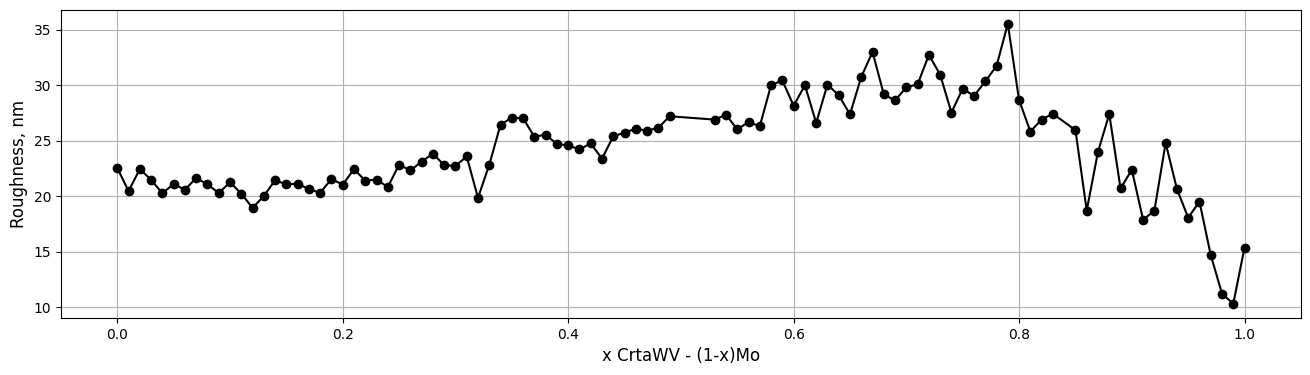

In [10]:
fig = plt.figure(figsize=(16, 4))

plt.plot(*roughness_array.T, 'ko-', )
plt.ylabel('Roughness, nm', fontsize=12)
plt.xlabel("x CrtaWV - (1-x)Mo", fontsize=12)
plt.grid()

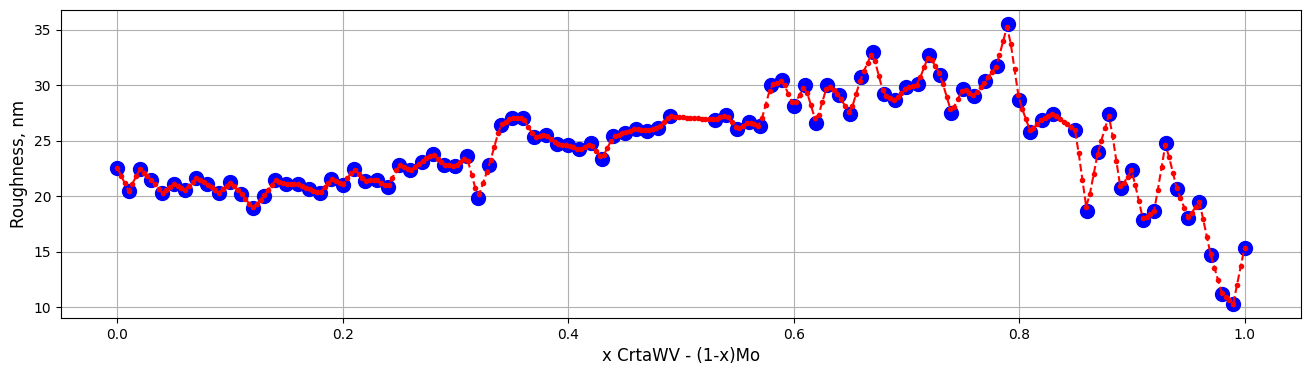

In [11]:
#extend array

x_new = np.linspace(0,1,300)

r_new = np.interp(x_new, roughness_array[:,0], roughness_array[:,1])
rough_ar_new = np.array([x_new, r_new]).T

fig, ax = plt.subplots(figsize=(16, 4), sharex=True)

ax.plot(roughness_array[:,0], roughness_array[:,1], 'o', color='b', ms=10)
ax.plot(rough_ar_new[:,0], rough_ar_new[:,1], 'o--', color='r', ms=3)

plt.ylabel('Roughness, nm', fontsize=12)
plt.xlabel("x CrtaWV - (1-x)Mo", fontsize=12)
ax.grid()

# Co-navigation functions

In [13]:
#@title Emulation mode
def seeds_exp(X, rough_array, n=5):
  seeds = np.random.choice(np.arange(len(X)), n, replace=False)

  return seeds, X[seeds], rough_array[seeds] + np.random.uniform(-1, 1, len(seeds))


def seeds_theory(X, sputtering_params, n=5, rough_norm_coef=10):
  seeds = np.random.choice(np.arange(len(X)), n, replace=False)
  _film = sputtering_params['film'].copy()

  y_seed = np.array([])

  for i, x in enumerate(X[seeds]):
    print(f'Seed {i}/{len(seeds)}')
    sputtering_params['film'] = _film
    sr = theory_calculation(x, sputtering_params, rough_norm_coef=rough_norm_coef)
    y_seed = np.append(y_seed, sr)

  return seeds, X[seeds], y_seed

def theory_calculation(x, sputtering_params, rough_norm_coef=10):
  flow = tt([x*100., (1-x)*100.])
  sputtering_params['flow'] = flow
  film_r = sputtering(**sputtering_params)
  sr = surface_roughness(np.argmin((film_r > 0), axis=0), rough_norm_coef)
  return sr


In [14]:
def gp_prediction(X_train,
                  y_train,
                  X,
                  lengthscale_prior= SmoothedBoxPrior(.05, .5, sigma=0.02),
                  noise_prior = GammaPrior(1.5, 1.5),
                  outputscale_prior = GammaPrior(2.0, 0.1),
                  input_transform=None,#Normalize(d=d),          # maps each dim to [0,1]
                  outcome_transform=None
                  ):
    X_train = torch.as_tensor(X_train, dtype=torch.double).reshape(len(X_train), -1)
    y_train = torch.as_tensor(y_train, dtype=torch.double).reshape(-1, 1)
    X_torch = torch.as_tensor(X, dtype=torch.double).reshape(len(X), -1)

    gp_model = make_gp_model(X_train, y_train,
                             lengthscale_prior= lengthscale_prior,
                             noise_prior = noise_prior,
                             outputscale_prior = outputscale_prior,
                             input_transform = input_transform,#Normalize(d=d),          # maps each dim to [0,1]
                             outcome_transform = outcome_transform#Standardize(m=1),
                            )

    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_mll(mll)

    print("Learned noise:", gp_model.likelihood.noise.item())
    print("Lengthscale:", gp_model.covar_module.base_kernel.lengthscale.detach().cpu().numpy())
    print("Outputscale:", gp_model.covar_module.outputscale.item())


    gp_model.eval()
    with torch.no_grad():
        posterior = gp_model.posterior(X_torch)
        mean = posterior.mean.squeeze(-1)
        var = posterior.variance.squeeze(-1)

    return gp_model, np.array(mean), np.array(var)

def make_gp_model(X_train, y_train,
                  lengthscale_prior= SmoothedBoxPrior(.05, .5, sigma=0.02),
                  noise_prior = GammaPrior(1.5, 1.5),
                  outputscale_prior = GammaPrior(2.0, 0.1),
                  input_transform=None,#Normalize(d=d),          # maps each dim to [0,1]
                  outcome_transform=None#Standardize(m=1),
                  ):
    likelihood = GaussianLikelihood()
    covar_module = ScaleKernel(MaternKernel(
                                         n=1.5,
                                         lengthscale_prior=lengthscale_prior,
                                         noise_prior = noise_prior,
                                         ard_num_dims=X_train.shape[1],
                                         ),
                               outputscale_prior = outputscale_prior
                               )
    model = SingleTaskGP(X_train, y_train,
                         covar_module=covar_module,
                         input_transform = input_transform,
                         outcome_transform=outcome_transform,
                         likelihood=likelihood)

    return model

In [15]:
def mse_calculation(X_points, y_points, gp_model):
    X_p_torch = torch.as_tensor(X_points, dtype=torch.float64).reshape(len(X_points), -1)

    gp_model.eval()
    with torch.no_grad():
        posterior = gp_model.posterior(X_p_torch)
        y_p_pred = posterior.mean.squeeze(-1)
    _mse = torch.mean((tt(y_points, dtype=torch.float64) - y_p_pred)**2)
    return float(_mse)


# Visualization

In [16]:

def pred_visualization(X, pred_th, X_train_th, y_train_th, ind_th, mem_tail,
                            X_exp = None, pred_exp = None, X_train_exp = None, y_train_exp = None, ind_exp = None, iter = None):
  fig, ax = plt.subplots(figsize=(5,4))

  #theory
  ax.plot(X, pred_th[0], '-', label='theory', c='b')
  ax.fill_between(X, pred_th[0]-pred_th[1], pred_th[0]+pred_th[1], color='b', alpha=0.2)

  if len(X_train_th) > mem_tail:
      ax.plot(X_train_th, y_train_th, 'o', c='gray')
      ax.plot(X_train_th[-mem_tail:], y_train_th[-mem_tail:], 'o', c='b')

  else:
      ax.plot(X_train_th, y_train_th, 'o', c='b')

  ax.scatter(X[ind_th], pred_th[0][ind_th], c='b', marker='x', s=30)

  #experiment
  if X_exp is not None:
    ax.plot(X_exp, pred_exp[0], '-', c='r', label = 'experiment')
    ax.fill_between(X_exp, pred_exp[0]-pred_exp[1], pred_exp[0]+pred_exp[1], color='r', alpha=0.2)

    ax.plot(X_train_exp, y_train_exp, 'o', c='r')
    ax.scatter(X_exp[ind_exp], pred_exp[0][ind_exp], c='red', marker='x', s=30)

  if iter is not None:
     fig.suptitle(f'--- iter {iter} ---')
  ax.legend()
  plt.show()

  return fig

# Experiment

In [17]:
#---------------------------------------------------
#........GENERAL.........
#---------------------------------------------------
n_steps = 201
exp_th = 10       #experiment/theory ratio

#---------------------------------------------------
#........THEORY.........
#---------------------------------------------------
N = 5             #number of seed points theory min 2
mem_tail = 10      #'tail' to train T-model, should be less or equal to the upd_rate

t = 100            #sputtering duration (100 particles/s for each particle type)
E0 = .2
n_hops = 3
T = 700

k_up = .15
k_down = .1
dist = 2

atoms=['A', 'B']
nodes= hex_lattice(nx=300, ny=200)

#ONLY for UCB with beta changing
#beta0 = 100
#beta_last = 0.001
#beta_sequence = sigmoid_decay(beta0, beta_last, n_steps, a=2.5, b=0)

X = tt(np.linspace(0,1,300)) #composition T

#---------------------------------------------------
#........EXPERIMENT.........
#---------------------------------------------------
N_exp = 5         #number of seed points exp
n_runs = 6        #parallel runs for kMC film sputtering

X_exp = tt(rough_ar_new[:,0]) #composition exp
new_r = tt(rough_ar_new[:,1]) #ground truth roughness for simulation

#---------------------------------------------------
#........OUTER LOOP.........
#---------------------------------------------------
upd_rate = 10  #theory update rate

#outer theory update object space
a_a = np.linspace(1e-2, 10e-2, 30) #for Eaa
b_b = np.linspace(1e-2, 10e-2, 30) #for Ebb
a_b = np.linspace(1e-2, 10e-2, 30) #for Eab
coord_adj = np.array(list(product(a_a, a_b, b_b)))


/tmp/ipython-input-640727714.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  Ea_log = tt([current_Ea, ])



----------------- Seed points theory -----------------

Current Ea {('A', 'A'): np.float64(0.09689655172413793), ('A', 'B'): np.float64(0.1), ('B', 'B'): np.float64(0.04724137931034483)}
Seed 0/5
Seed 1/5
Seed 2/5
Seed 3/5
Seed 4/5
Learned noise: 41.71582027913659
Lengthscale: [[0.11575027]]
Outputscale: 12.876381110077867

----------------- Seed points experiment -----------------



/tmp/ipython-input-263293459.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return seeds, X[seeds], rough_array[seeds] + np.random.uniform(-1, 1, len(seeds))


Learned noise: 0.00010855528857318071
Lengthscale: [[0.14017694]]
Outputscale: 9.677575970402536


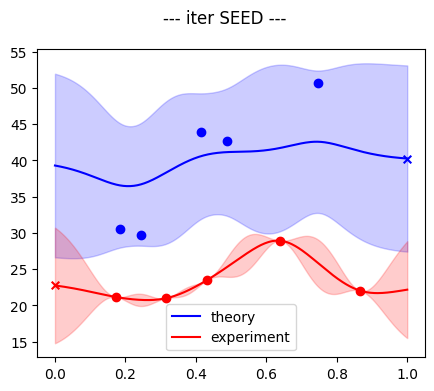


----------------- Iteration theory 0 -----------------

Learned noise: 52.42021561129832
Lengthscale: [[0.22455482]]
Outputscale: 14.409479507169573

----------------- Iteration exp 0 -----------------

Learned noise: 0.00010784808186211946
Lengthscale: [[0.15074427]]
Outputscale: 8.718622294017843


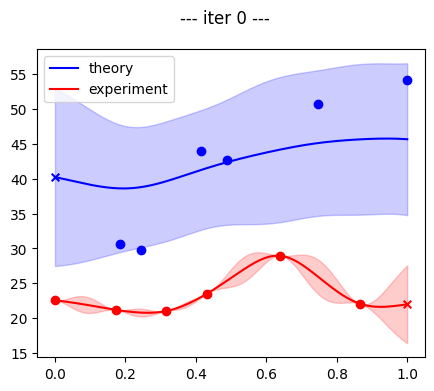


----------------- Iteration theory 1 -----------------

Learned noise: 116.20577919929741
Lengthscale: [[0.29726169]]
Outputscale: 12.297737215328313


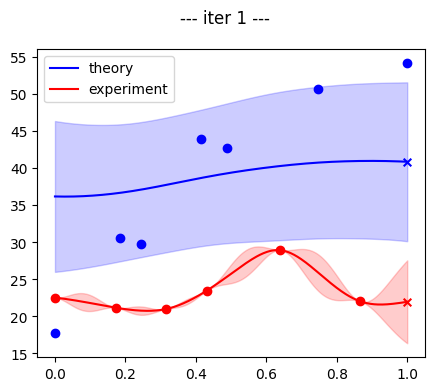


----------------- Iteration theory 2 -----------------

Learned noise: 13.589138957920463
Lengthscale: [[0.34327071]]
Outputscale: 43.715172821284625


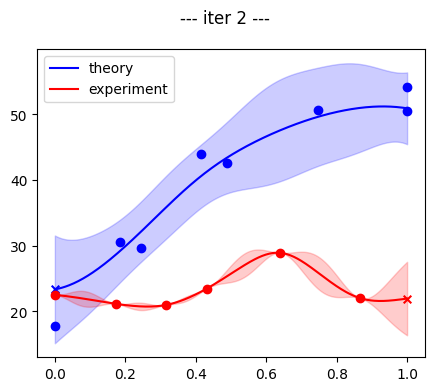


----------------- Iteration theory 3 -----------------

Learned noise: 7.27584018138706
Lengthscale: [[0.34783731]]
Outputscale: 48.729093963459675


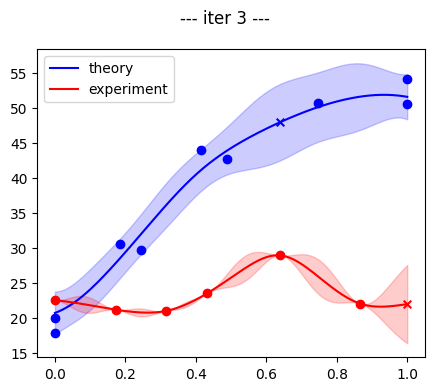


----------------- Iteration theory 4 -----------------

Learned noise: 6.0088870117054975
Lengthscale: [[0.35983315]]
Outputscale: 49.184740867630836


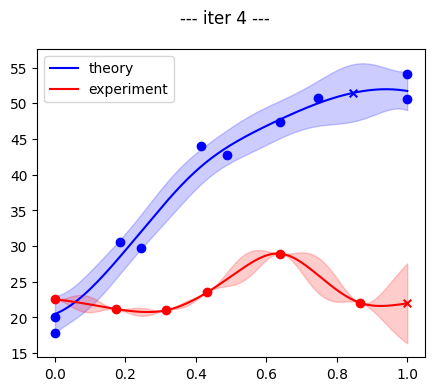


----------------- Iteration theory 5 -----------------

Learned noise: 6.9116697613409075
Lengthscale: [[0.33592723]]
Outputscale: 49.56242225997332


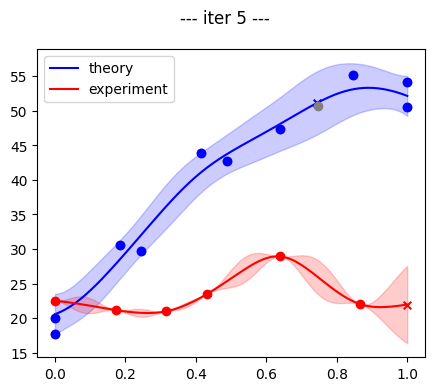


----------------- Iteration theory 6 -----------------

Learned noise: 6.592759146377623
Lengthscale: [[0.32232342]]
Outputscale: 49.50584692881761


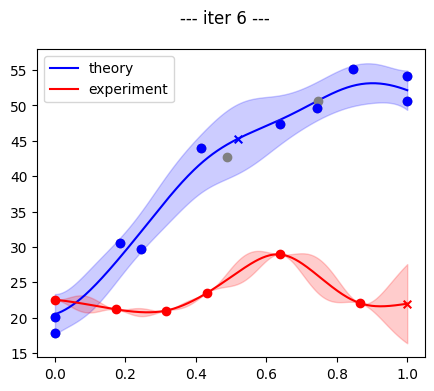


----------------- Iteration theory 7 -----------------

Learned noise: 4.786318794580033
Lengthscale: [[0.29697642]]
Outputscale: 50.299664836020945


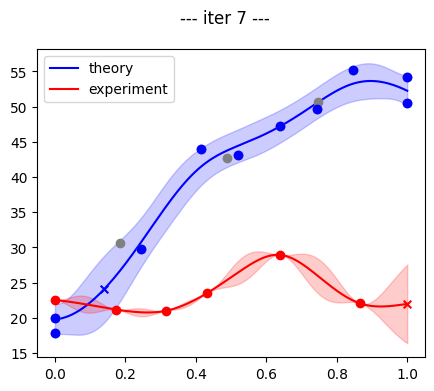


----------------- Iteration theory 8 -----------------

Learned noise: 3.785079580116274
Lengthscale: [[0.28389493]]
Outputscale: 50.31686301866311


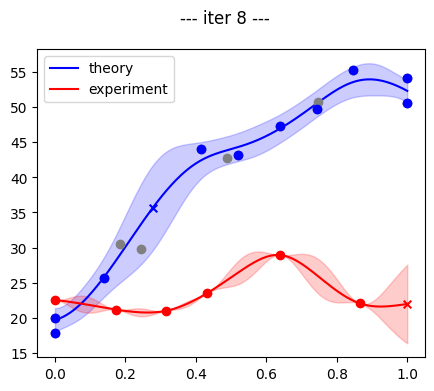


----------------- Iteration theory 9 -----------------

Learned noise: 3.1105233759681443
Lengthscale: [[0.38449403]]
Outputscale: 50.87739684388635


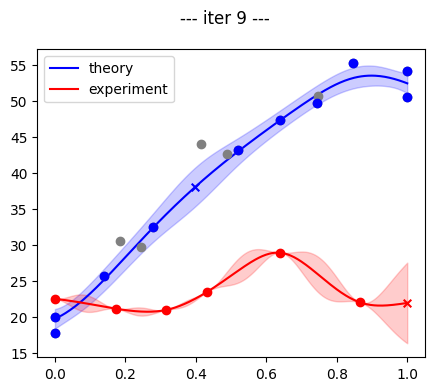


----------------- Iteration theory 10 -----------------

Learned noise: 2.6935836034235945
Lengthscale: [[0.32465048]]
Outputscale: 49.38609089772095

----------------- Iteration exp 10 -----------------

Learned noise: 0.00010111305371265473
Lengthscale: [[0.2258893]]
Outputscale: 17.766776016551034


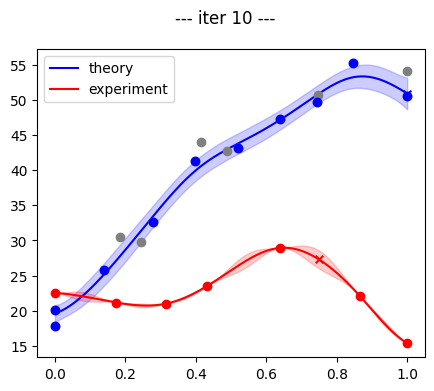


----------------- Theory model tune iter_10 -----------------

MSE 449.57
Current Ea: {('A', 'A'): tensor(0.0534, dtype=torch.float64), ('A', 'B'): tensor(0.0379, dtype=torch.float64), ('B', 'B'): tensor(0.0783, dtype=torch.float64)}

----------------- Iteration theory 11 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 135.31248816599947
Lengthscale: [[0.23248417]]
Outputscale: 11.031569640538429


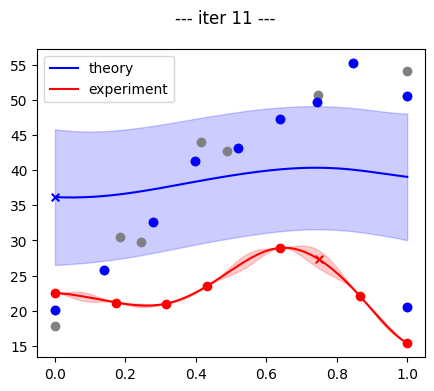


----------------- Iteration theory 12 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 121.3925648674253
Lengthscale: [[0.1684799]]
Outputscale: 10.921303988463354


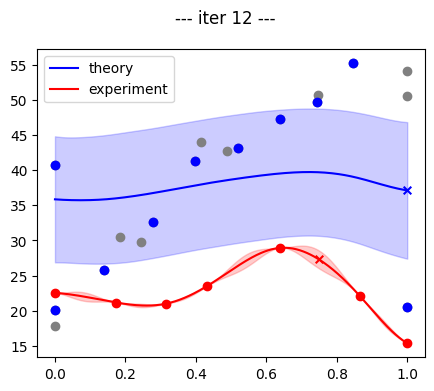


----------------- Iteration theory 13 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 106.00572879939081
Lengthscale: [[0.0768363]]
Outputscale: 12.70453550004581


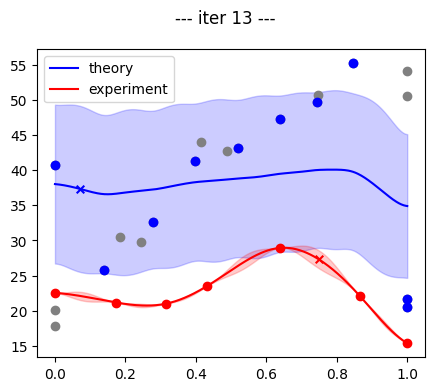


----------------- Iteration theory 14 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 98.1571605441003
Lengthscale: [[0.05988505]]
Outputscale: 12.475406138651321


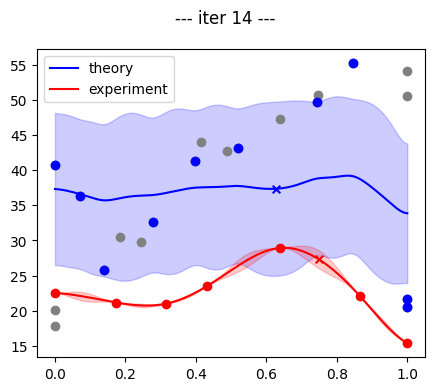


----------------- Iteration theory 15 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 85.10134586325958
Lengthscale: [[0.04904551]]
Outputscale: 11.311032282808481


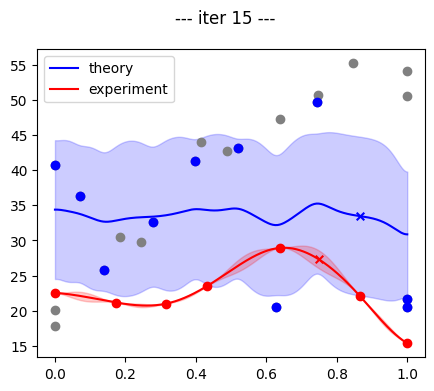


----------------- Iteration theory 16 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 63.218025488149046
Lengthscale: [[0.21072395]]
Outputscale: 13.203318573313394


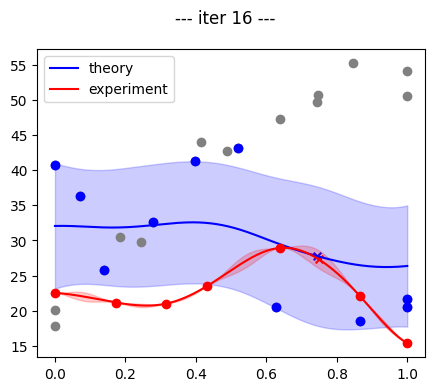


----------------- Iteration theory 17 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 38.9724358271746
Lengthscale: [[0.2621938]]
Outputscale: 17.393598756792077


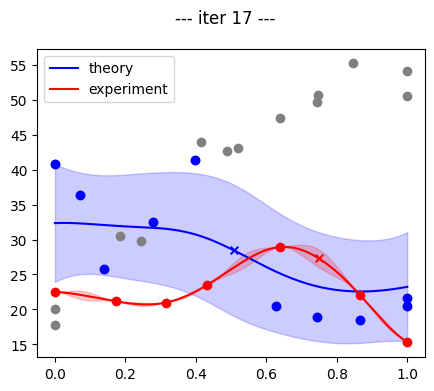


----------------- Iteration theory 18 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 30.69481005744752
Lengthscale: [[0.30582878]]
Outputscale: 22.036506432928174


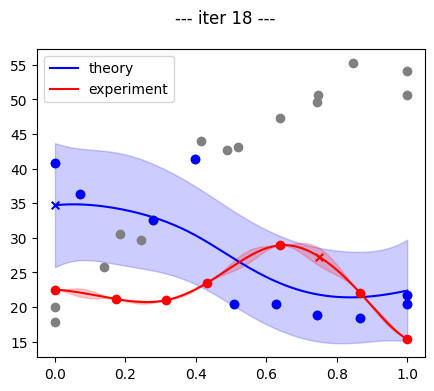


----------------- Iteration theory 19 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 25.905885930831147
Lengthscale: [[0.29497513]]
Outputscale: 26.277193050681465


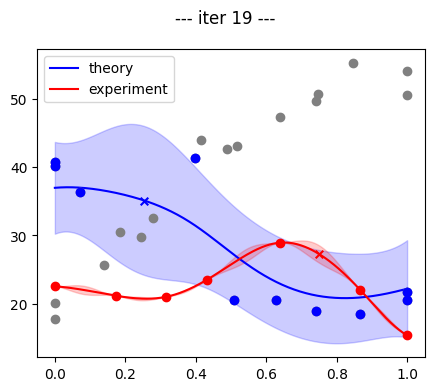


----------------- Iteration theory 20 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 1.0005860422639987
Lengthscale: [[0.40506804]]
Outputscale: 33.86328273045048

----------------- Iteration exp 20 -----------------

Learned noise: 0.00012132663360946749
Lengthscale: [[0.18172487]]
Outputscale: 17.118318652645755


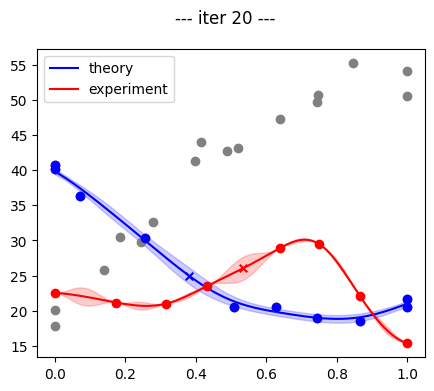


----------------- Theory model tune iter_20 -----------------

MSE 90.83
Current Ea: {('A', 'A'): tensor(0.0659, dtype=torch.float64), ('A', 'B'): tensor(0.0534, dtype=torch.float64), ('B', 'B'): tensor(0.0628, dtype=torch.float64)}

----------------- Iteration theory 21 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 0.9051198900731275
Lengthscale: [[0.3682075]]
Outputscale: 33.47347093122368


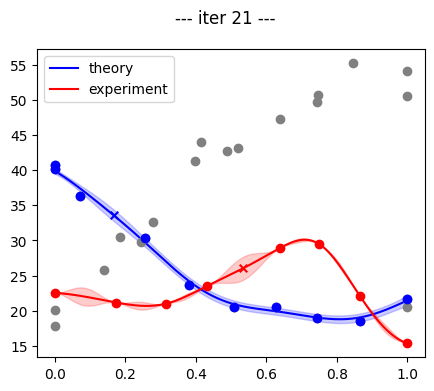


----------------- Iteration theory 22 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 9.530611739964277
Lengthscale: [[0.33344324]]
Outputscale: 24.530906263724233


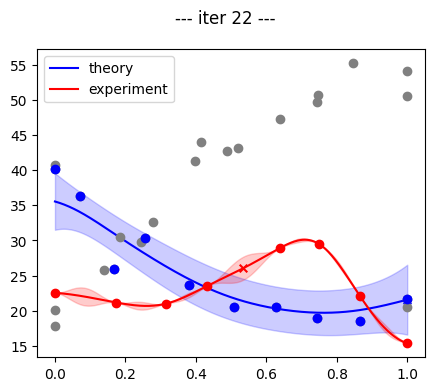


----------------- Iteration theory 23 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 14.94474486244726
Lengthscale: [[0.24447666]]
Outputscale: 20.988930910476025


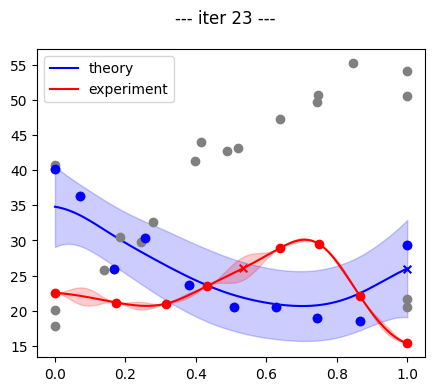


----------------- Iteration theory 24 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 32.61708780498096
Lengthscale: [[0.17010258]]
Outputscale: 13.376087458735814


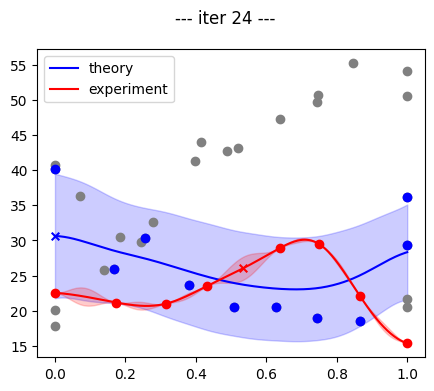


----------------- Iteration theory 25 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 33.892329003797826
Lengthscale: [[0.05911286]]
Outputscale: 11.16075976985997


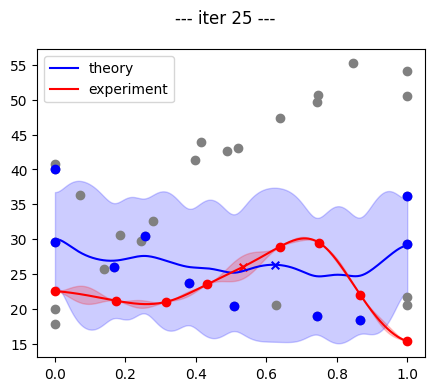


----------------- Iteration theory 26 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 27.28298674262809
Lengthscale: [[0.17095556]]
Outputscale: 11.044428026732183


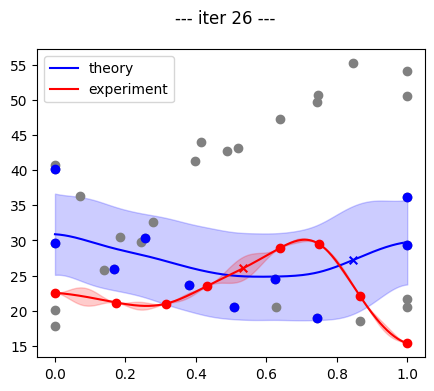


----------------- Iteration theory 27 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 23.18845377465934
Lengthscale: [[0.18676086]]
Outputscale: 9.727760552581065


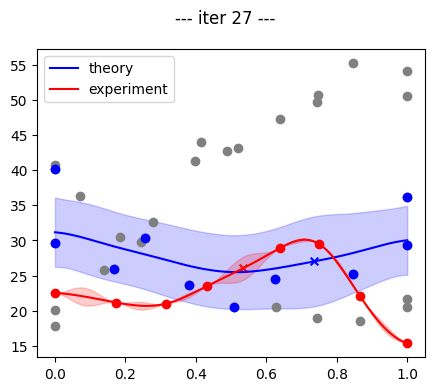


----------------- Iteration theory 28 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 20.17252757523892
Lengthscale: [[0.04933157]]
Outputscale: 7.201125738765724


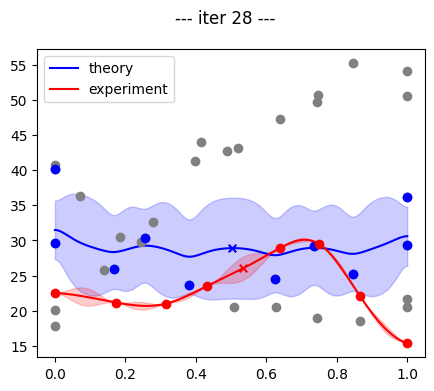


----------------- Iteration theory 29 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 10.066127348626447
Lengthscale: [[0.04993186]]
Outputscale: 7.25209339711638


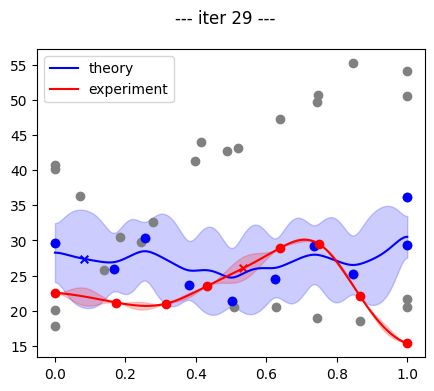


----------------- Iteration theory 30 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 10.063630319110166
Lengthscale: [[0.25802722]]
Outputscale: 8.472381508026093

----------------- Iteration exp 30 -----------------

Learned noise: 0.00010086905828454841
Lengthscale: [[0.19020793]]
Outputscale: 17.48218026903001


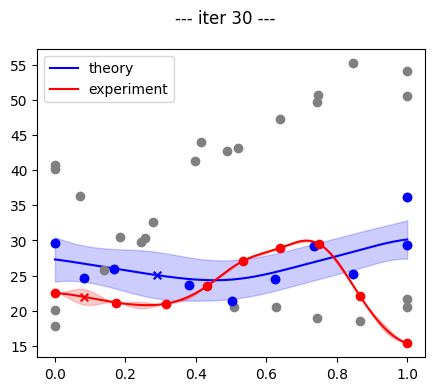


----------------- Theory model tune iter_30 -----------------

MSE 38.46
Current Ea: {('A', 'A'): tensor(0.0969, dtype=torch.float64), ('A', 'B'): tensor(0.0193, dtype=torch.float64), ('B', 'B'): tensor(0.0162, dtype=torch.float64)}

----------------- Iteration theory 31 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 21.69954447368493
Lengthscale: [[0.1758706]]
Outputscale: 11.719477715323713


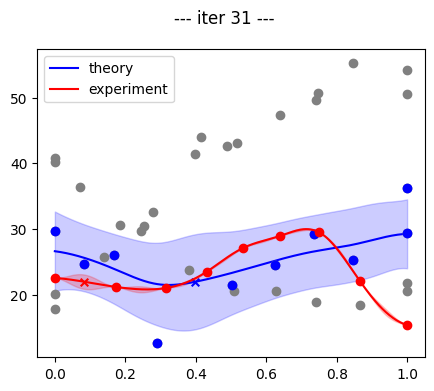


----------------- Iteration theory 32 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 13.165633214291695
Lengthscale: [[0.17288967]]
Outputscale: 19.650415680120997


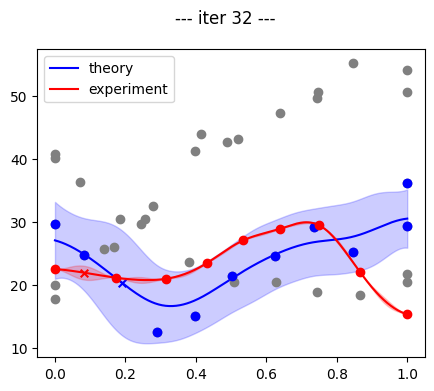


----------------- Iteration theory 33 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 5.925738436599765
Lengthscale: [[0.15378069]]
Outputscale: 28.62947746554175


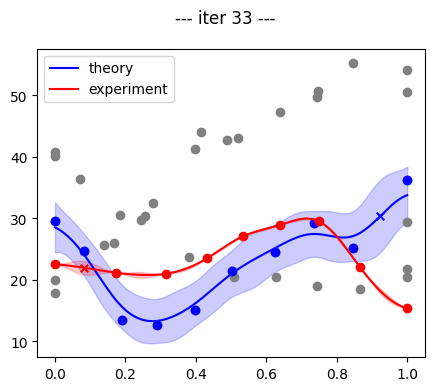


----------------- Iteration theory 34 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 54.503229331899135
Lengthscale: [[0.19338472]]
Outputscale: 14.727887216431522


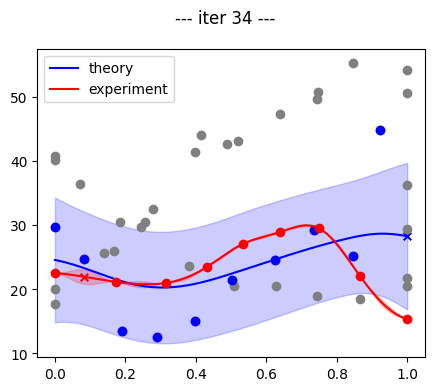


----------------- Iteration theory 35 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 89.74735791288325
Lengthscale: [[0.23720175]]
Outputscale: 18.431826323490693


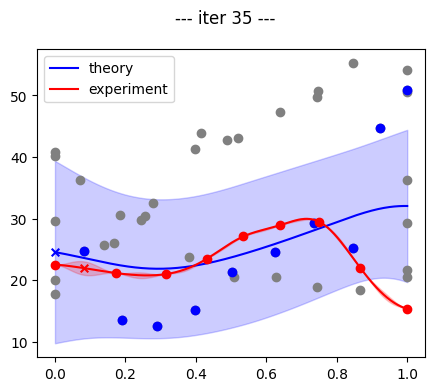


----------------- Iteration theory 36 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 111.27078921034858
Lengthscale: [[0.27527979]]
Outputscale: 16.858690140925052


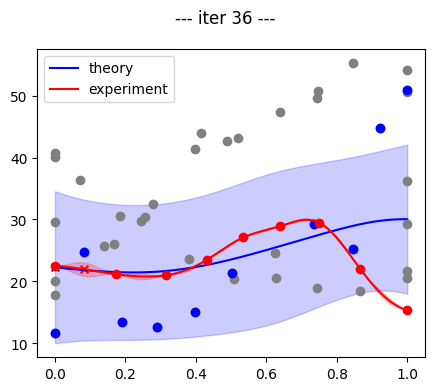


----------------- Iteration theory 37 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 87.17507631333854
Lengthscale: [[0.29587408]]
Outputscale: 24.97431241243953


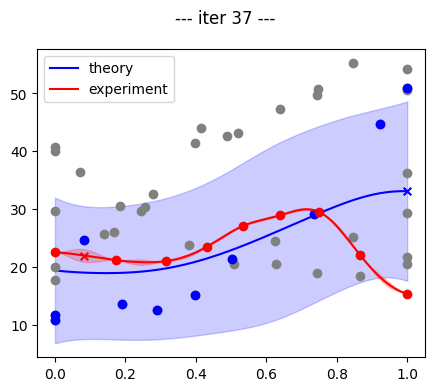


----------------- Iteration theory 38 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 30.737598988587113
Lengthscale: [[0.29492688]]
Outputscale: 48.92846150014727


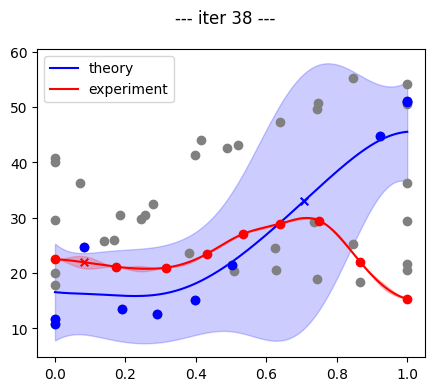


----------------- Iteration theory 39 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 35.23662221164825
Lengthscale: [[0.28363652]]
Outputscale: 47.02738306600171


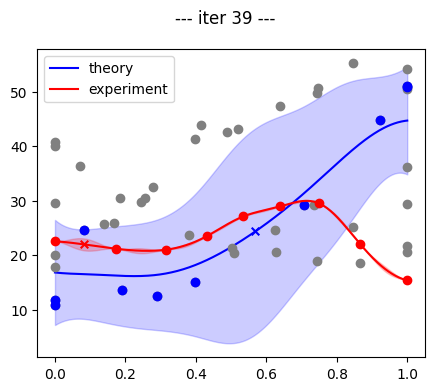


----------------- Iteration theory 40 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 0.2742678123507415
Lengthscale: [[0.32800383]]
Outputscale: 66.3701290619111

----------------- Iteration exp 40 -----------------

Learned noise: 0.00010051353675167192
Lengthscale: [[0.18734387]]
Outputscale: 17.462075455211302


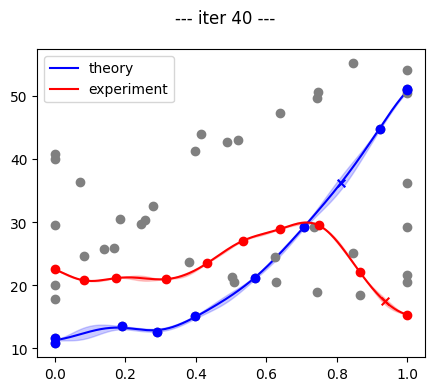


----------------- Theory model tune iter_40 -----------------

MSE 204.51
Current Ea: {('A', 'A'): tensor(0.0286, dtype=torch.float64), ('A', 'B'): tensor(0.0348, dtype=torch.float64), ('B', 'B'): tensor(0.0814, dtype=torch.float64)}

----------------- Iteration theory 41 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 197.0723434105479
Lengthscale: [[0.24409874]]
Outputscale: 14.01672642628327


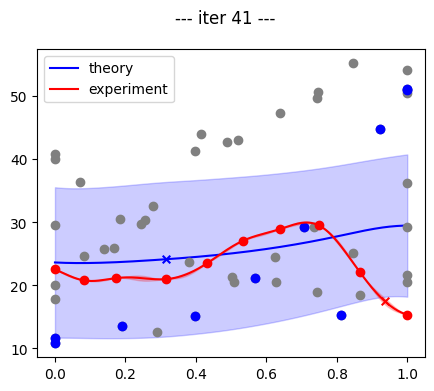


----------------- Iteration theory 42 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 187.69973628538557
Lengthscale: [[0.18538221]]
Outputscale: 13.71095916309946


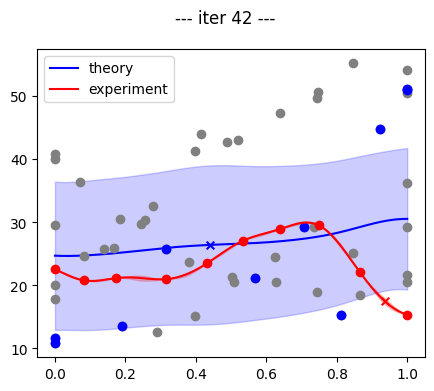


----------------- Iteration theory 43 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 176.65793132111887
Lengthscale: [[0.10489105]]
Outputscale: 13.818100778233353


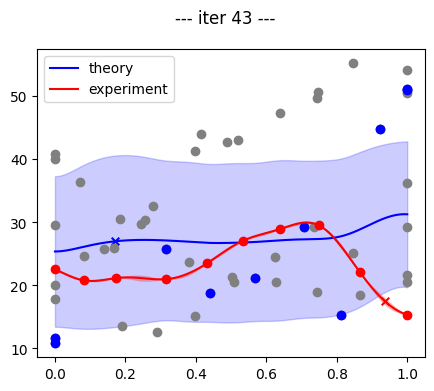


----------------- Iteration theory 44 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 0.2092368778219506
Lengthscale: [[0.04650264]]
Outputscale: 61.618767737297425


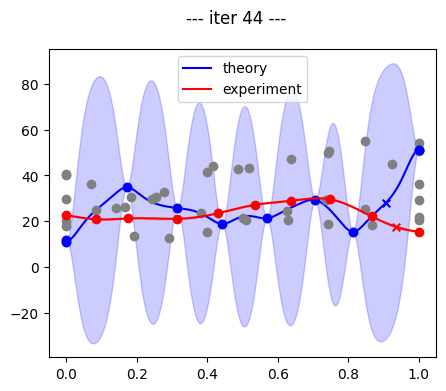


----------------- Iteration theory 45 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 134.35566520767912
Lengthscale: [[0.04936716]]
Outputscale: 10.420548778215105


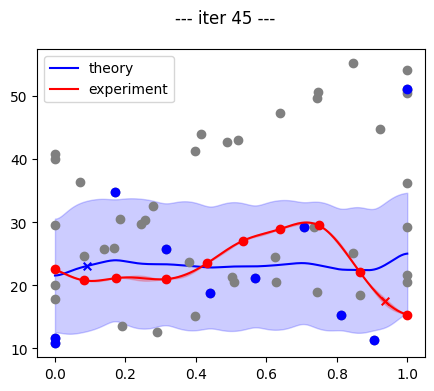


----------------- Iteration theory 46 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 136.63574916234649
Lengthscale: [[0.04942833]]
Outputscale: 9.785913079888829


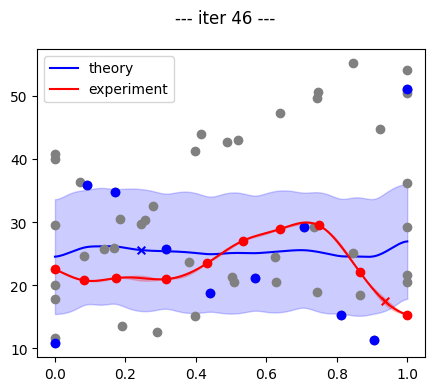


----------------- Iteration theory 47 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 112.20295669680593
Lengthscale: [[0.04966736]]
Outputscale: 9.892937382875278


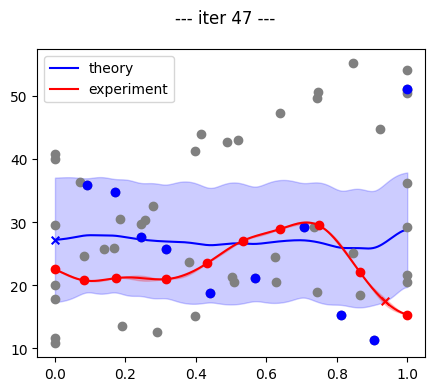


----------------- Iteration theory 48 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 55.8860210897814
Lengthscale: [[0.23084357]]
Outputscale: 18.689877909367254


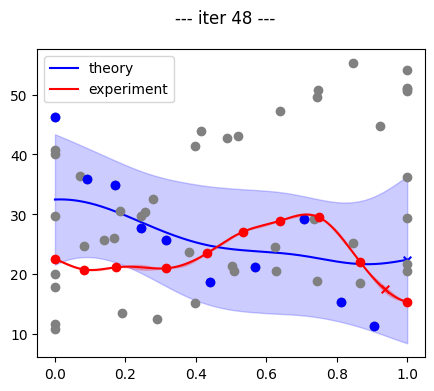


----------------- Iteration theory 49 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 8.094914364958466
Lengthscale: [[0.27977699]]
Outputscale: 42.26494495328572


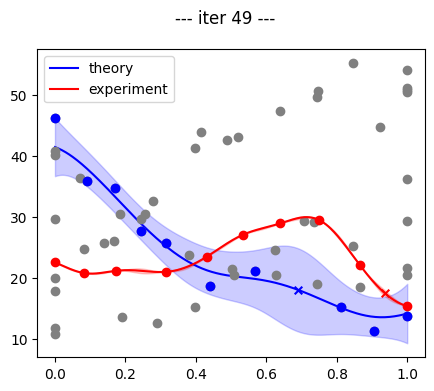


----------------- Iteration theory 50 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 6.502814580991469
Lengthscale: [[0.33553509]]
Outputscale: 45.32929165412851

----------------- Iteration exp 50 -----------------

Learned noise: 2.966970574537284
Lengthscale: [[0.20695717]]
Outputscale: 14.376134954953333


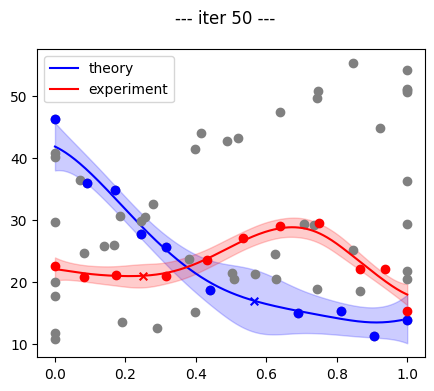


----------------- Theory model tune iter_50 -----------------

MSE 135.12
Param. Learned noise: 0.00010000651274983199
Param. Lengthscale: [[0.50059475 0.25639407 0.50012622]]
Param. Outputscale: 1.1430001955108178
IND MSE: 12071
EI stats: mean -59.62868111851493 max 28.02426139670446 min -447.9424772516336 std 68.55407741539221


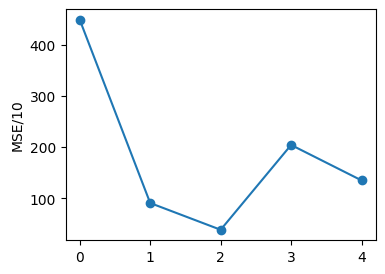

Current Ea: {('A', 'A'): tensor(0.0503, dtype=torch.float64), ('A', 'B'): tensor(0.0472, dtype=torch.float64), ('B', 'B'): tensor(0.0441, dtype=torch.float64)}

----------------- Iteration theory 51 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 7.607313511729301
Lengthscale: [[0.31390542]]
Outputscale: 43.96703011005759


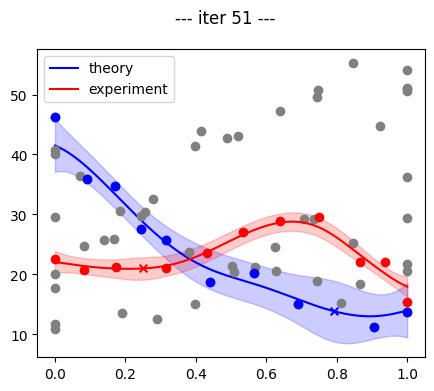


----------------- Iteration theory 52 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 19.556413631150324
Lengthscale: [[0.30071863]]
Outputscale: 35.276407687562944


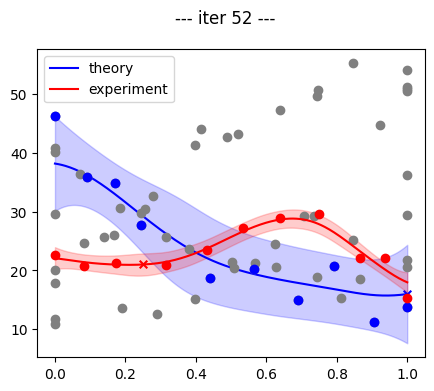


----------------- Iteration theory 53 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 27.54878506511366
Lengthscale: [[0.32448981]]
Outputscale: 29.761158366605557


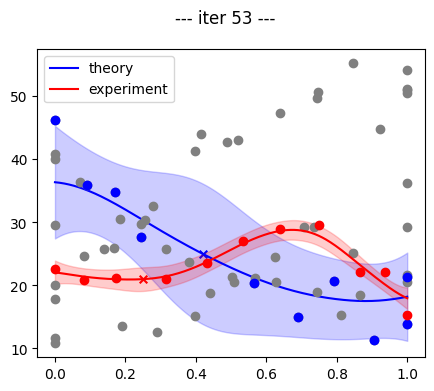


----------------- Iteration theory 54 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 32.63218579938002
Lengthscale: [[0.29753949]]
Outputscale: 27.474420624086495


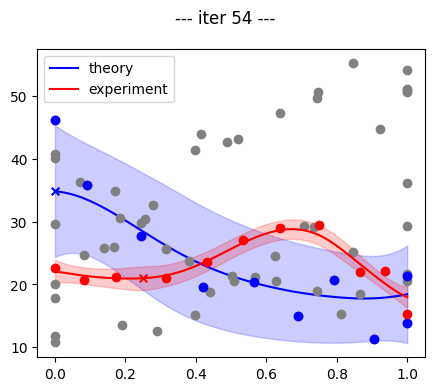


----------------- Iteration theory 55 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 81.06837217137618
Lengthscale: [[0.29241016]]
Outputscale: 10.619466798383858


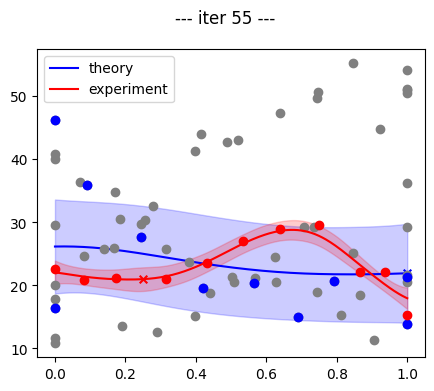


----------------- Iteration theory 56 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 72.58064285866377
Lengthscale: [[0.33656623]]
Outputscale: 9.292751271703285


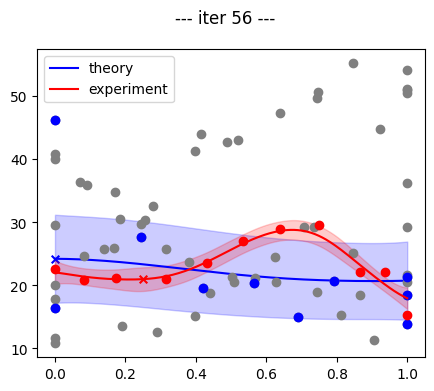


----------------- Iteration theory 57 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 78.73524410414856
Lengthscale: [[0.35925325]]
Outputscale: 7.79185235724199


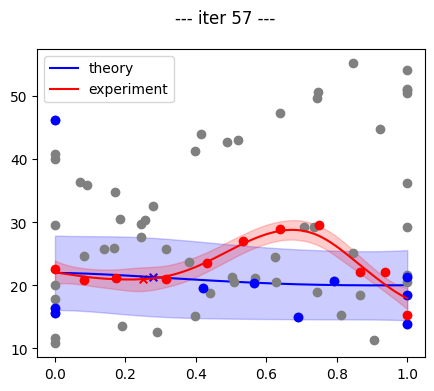


----------------- Iteration theory 58 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 6.436948208869361
Lengthscale: [[0.04888289]]
Outputscale: 3.373526838019246


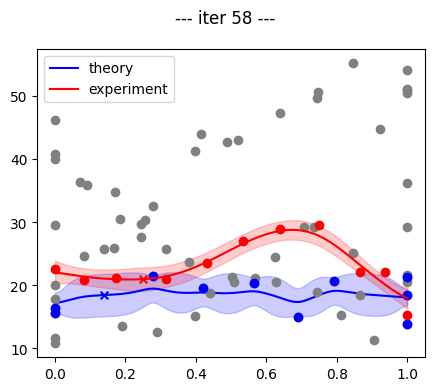


----------------- Iteration theory 59 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 1.8709717049068046
Lengthscale: [[0.04652116]]
Outputscale: 4.21403563020911


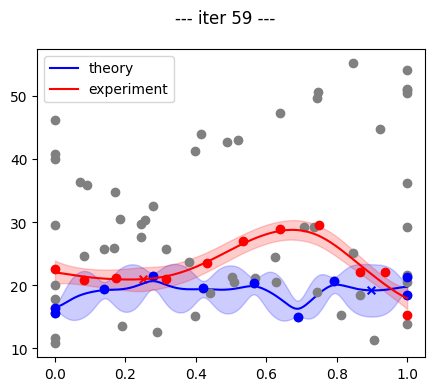


----------------- Iteration theory 60 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 1.4649709406014262
Lengthscale: [[0.04894864]]
Outputscale: 2.654631021455832

----------------- Iteration exp 60 -----------------

Learned noise: 2.9178205965363304
Lengthscale: [[0.20681055]]
Outputscale: 14.022753777672365


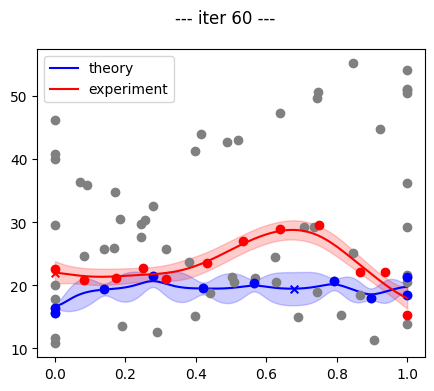


----------------- Theory model tune iter_60 -----------------

MSE 27.96
Param. Learned noise: 0.00010000259219976843
Param. Lengthscale: [[0.50075014 0.25576761 0.50056062]]
Param. Outputscale: 0.9800083233333972
IND MSE: 9436
EI stats: mean -69.67166042946491 max 23.973548414893273 min -447.97422646774834 std 69.67662736549406


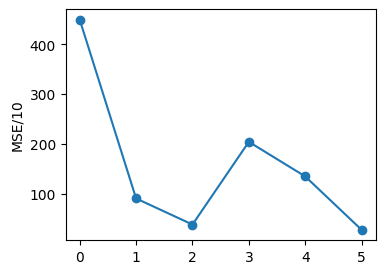

Current Ea: {('A', 'A'): tensor(0.0410, dtype=torch.float64), ('A', 'B'): tensor(0.0534, dtype=torch.float64), ('B', 'B'): tensor(0.0597, dtype=torch.float64)}

----------------- Iteration theory 61 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 1.5150915757501693
Lengthscale: [[0.09448382]]
Outputscale: 3.1675941771609737


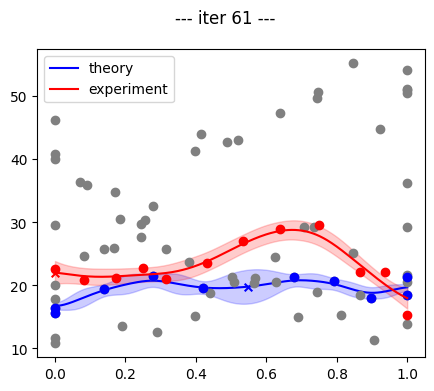


----------------- Iteration theory 62 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 1.4784165542075085
Lengthscale: [[0.09100776]]
Outputscale: 2.9534508915543274


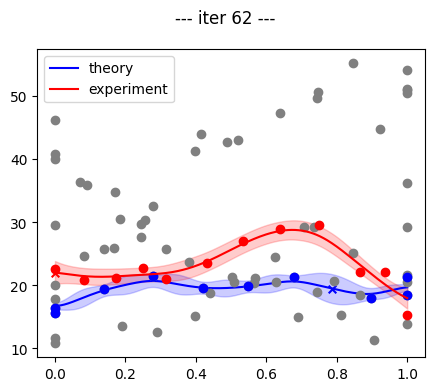


----------------- Iteration theory 63 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


Learned noise: 0.2808708815035468
Lengthscale: [[0.04947927]]
Outputscale: 3.337870288695433


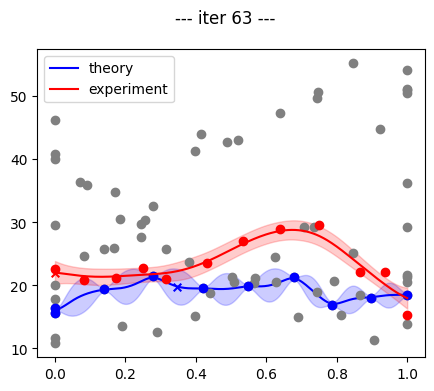


----------------- Iteration theory 64 -----------------



/tmp/ipython-input-2716853750.py:106: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rate = nu0 * np.exp( -E_diff / (kB * T) )


In [ ]:
#---------------------------------------------------
#........Co-navigation.........
#---------------------------------------------------

Ea_model_seed_ind = np.random.randint(0,len(coord_adj), 10)
current_Ea = coord_adj[Ea_model_seed_ind[0]]

#logs


figs = []
Ea_log = tt([current_Ea, ])
mse = []

res_dict = {'X_th': X,               #compositions theory
            'X_exp': X_exp,          #compositions exp
            'coord_adj': coord_adj   #outer loop field
           }

print('\n----------------- Seed points theory -----------------\n')

dE={('A','A'): current_Ea[0],#5e-2,#current_Ea[0],
    ('A', 'B'): current_Ea[1],# 10e-2,
    ('B','B'): current_Ea[2]}#1e-2}#

sputtering_params = {
    'film': np.zeros(nodes.shape[:-1]).astype(int),
    'dE': dE,
    'atoms': atoms,
    't': t,
    'n_hops': n_hops,
    'dist': dist,
    'E0': E0,
    'k_up': k_up,
    'k_down': k_down,
    'T':T,
    }

print(f'Current Ea {dE}')
seeds_th, X_train_th, y_train_th = seeds_theory(X,
                                                sputtering_params,
                                                n=N,
                                                rough_norm_coef=10
                                                )

_, th_mean, th_var = gp_prediction(X_train_th[-mem_tail:],
                                   y_train_th[-mem_tail:],
                                   X,
                                   lengthscale_prior= SmoothedBoxPrior(.05, .5, sigma=0.02),
                                   noise_prior = GammaPrior(1.5, 1.5),
                                   outputscale_prior = GammaPrior(2.0, 0.1),
                                   input_transform=None,#Normalize(d=d),          # maps each dim to [0,1]
                                   outcome_transform=None
                                       )

ind_next_th = np.argmax(th_var)


res_dict['y_seed_th'] = y_train_th
res_dict['seed_th'] = seeds_th

print('\n----------------- Seed points experiment -----------------\n')

seeds_e, X_train_exp, y_train_exp = seeds_exp(X_exp, new_r, n=N_exp)

res_dict['y_seed_exp'] = y_train_exp
res_dict['seed_exp'] = seeds_e

_, exp_mean, exp_var = gp_prediction(X_train_exp,
                                     y_train_exp,
                                     X,
                                     lengthscale_prior= SmoothedBoxPrior(.05, .5, sigma=0.02),
                                     noise_prior = GammaPrior(1.5, 1.5),
                                     outputscale_prior = GammaPrior(2.0, 0.1),
                                     input_transform=None,#Normalize(d=d),          # maps each dim to [0,1]
                                     outcome_transform=None
                                           )
ind_next_exp = np.argmax(exp_var)

fig = pred_visualization(X,
                       pred_th = np.array([th_mean, th_var]),
                       X_train_th = X_train_th,
                       y_train_th = y_train_th,
                       ind_th = ind_next_th,
                       mem_tail = mem_tail,

                       X_exp = X,
                       pred_exp = np.array([exp_mean, exp_var]),
                       X_train_exp = X_train_exp,
                       y_train_exp = y_train_exp,
                       ind_exp = ind_next_exp,

                       iter= 'SEED'
                      )

figs.append(fig)

for i in range(n_steps):
  #clear_output(wait=True)
  res_dict['iter_{}'.format(i)] = {}

  print(f'\n----------------- Iteration theory {i} -----------------\n')

  x_next_th = X[ind_next_th]
  y_next_th = theory_calculation(x_next_th, sputtering_params, rough_norm_coef=10)

  X_train_th = np.append(X_train_th, x_next_th)
  y_train_th = np.append(y_train_th, y_next_th)

  gp_th, th_mean, th_var = gp_prediction(X_train_th[-mem_tail:],
                                         y_train_th[-mem_tail:],
                                         X,
                                         lengthscale_prior= SmoothedBoxPrior(.05, .5, sigma=0.02),
                                         noise_prior = GammaPrior(1.5, 1.5),
                                         outputscale_prior = GammaPrior(2.0, 0.1),
                                         input_transform=None,#Normalize(d=d),          # maps each dim to [0,1]
                                         outcome_transform=None
                                         )

  ind_next_th = np.argmax(th_var)

  res_dict['iter_{}'.format(i)]['ind_th'] = ind_next_th
  res_dict['iter_{}'.format(i)]['X_train_th'] = X_train_th
  res_dict['iter_{}'.format(i)]['y_train_th'] = y_train_th
  res_dict['iter_{}'.format(i)]['pred_th'] = np.array([th_mean, th_var])


  if i % exp_th == 0:
    print(f'\n----------------- Iteration exp {i} -----------------\n')

    x_next_exp =     X[ind_next_exp]
    y_next_exp = r_new[ind_next_exp]

    X_train_exp = np.append(X_train_exp, x_next_exp)
    y_train_exp = np.append(y_train_exp, y_next_exp)

    gp_exp, exp_mean, exp_var = gp_prediction(X_train_exp,
                                              y_train_exp,
                                              X,
                                              lengthscale_prior= SmoothedBoxPrior(.05, .5, sigma=0.02),
                                              noise_prior = GammaPrior(1.5, 1.5),
                                              outputscale_prior = GammaPrior(2.0, 0.1),
                                              input_transform=None,#Normalize(d=d),          # maps each dim to [0,1]
                                              outcome_transform=None
                                              )

    ind_next_exp = np.argmax(exp_var)


  fig = pred_visualization(X,
                       pred_th = np.array([th_mean, th_var]),
                       X_train_th = X_train_th,
                       y_train_th = y_train_th,
                       ind_th = ind_next_th,
                       mem_tail = mem_tail,

                       X_exp = X,
                       pred_exp = np.array([exp_mean, exp_var]),
                       X_train_exp = X_train_exp,
                       y_train_exp = y_train_exp,
                       ind_exp = ind_next_exp,

                       iter= i
                      )
  figs.append(fig)

  if (i > 0) and (i % (upd_rate)==0):
    print(f'\n----------------- Theory model tune iter_{i} -----------------\n')

    _mse = mse_calculation(X_train_exp, y_train_exp, gp_th)
    mse.append(_mse)
    print(f'MSE {round(float(mse[-1]), 2)}')

    if len(mse) < 5: #initially choose randomly
      ind_mse = Ea_model_seed_ind[len(mse)]
    else:
      mse_tensor = torch.tensor(mse, dtype=torch.float64).unsqueeze(-1)

      bounds = torch.tensor([[a_a[0],  a_b[0],  b_b[0],],
                             [a_a[-1], a_b[-1], b_b[-1],]], dtype=torch.float32)

      inp_tf = Normalize(d=3, bounds=bounds)

      mse_m = make_gp_model(Ea_log, mse_tensor,
                            input_transform=inp_tf,
                            outcome_transform=Standardize(m=1),
                            #lengthscale_prior=SmoothedBoxPrior(0.03, 0.3, sigma=0.01),#GammaPrior(3.0, 6.0),
                            #noise_prior = SmoothedBoxPrior(0.1, 0.3, sigma=0.02),
                            #outputscale_prior = GammaPrior(2.0, 0.5),
                            #outputscale_prior=GammaPrior(2.0, 0.5)
                            )

      mll = ExactMarginalLogLikelihood(mse_m.likelihood, mse_m)
      fit_gpytorch_mll(mll)

      print("Param. Learned noise:", mse_m.likelihood.noise.item())
      print("Param. Lengthscale:", mse_m.covar_module.base_kernel.lengthscale.detach().cpu().numpy())
      print("Param. Outputscale:", mse_m.covar_module.outputscale.item())

      mse_m.eval()
      with torch.no_grad():
          posterior = mse_m.posterior(tt(coord_adj))
          mean = posterior.mean.squeeze(-1)
          var = posterior.variance.squeeze(-1)

      best_f = mse_tensor.min()  # Best observed value (for minimization)
      #ei = LogExpectedImprovement(model=mse_m, best_f=best_f, maximize=False)
      ei_values = -(mean - var**0.5)

      X_grid = mse_m.input_transform.transform(tt(coord_adj))
      #ei_values = ei(X_grid.unsqueeze(-2))
      ind_mse = torch.argmax(ei_values)
      print(f'IND MSE: {ind_mse}')

      print("EI stats: mean", ei_values.mean().item(),
      "max", ei_values.max().item(),
      "min", ei_values.min().item(),
      "std", ei_values.std().item())

      fig, ax = plt.subplots(figsize=(4,3))
      ax.plot(mse_tensor, 'o-')
      ax.set_ylabel('MSE/10')
      plt.show()

    #next parameters
    current_Ea = tt(coord_adj[ind_mse])
    Ea_log = torch.cat((Ea_log, current_Ea.unsqueeze(0)), dim=0)

    dE={('A','A'): current_Ea[0],
        ('A','B'): current_Ea[1],
        ('B','B'): current_Ea[2],}
    sputtering_params['dE'] = dE

    print(f'Current Ea: {dE}')

res_dict['mse'] = np.array(mse)








In [ ]:
figures_to_gif(figs, "20251123_exp2_UCB.gif", duration=300)

GIF saved to 20251123_exp2_UCB.gif


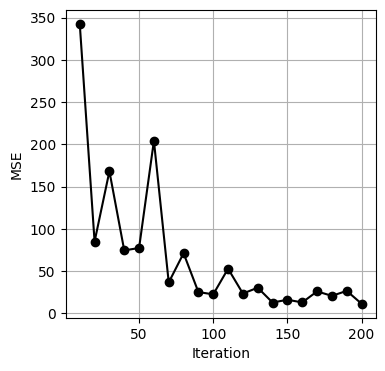

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(np.arange(len(res_dict['mse']))*10+10, res_dict['mse'], 'ko-')
plt.ylabel('MSE')
plt.xlabel('Iteration')
plt.grid()

In [ ]:
#vals_dict = res_dict.pop("params", None)
save_dict_to_hdf5("20251123_exp2_UCB.h5", res_dict)

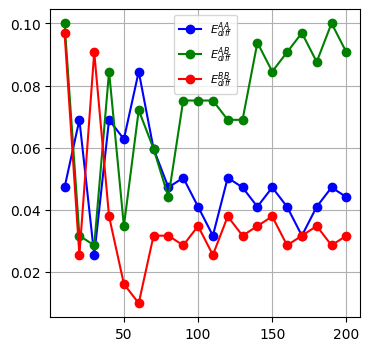

In [ ]:
labels = ['$E_{diff}^{AA}$', '$E_{diff}^{AB}$','$E_{diff}^{BB}$',]
colors = ['b', 'g', 'r']
plt.figure(figsize=(4,4))
for i, e_log in enumerate(Ea_log.T):
    plt.plot(np.arange(len(res_dict['mse']))*10+10, e_log[:-1], 'o-', label = labels[i], c=colors[i])

plt.grid()
plt.legend(fontsize=8)



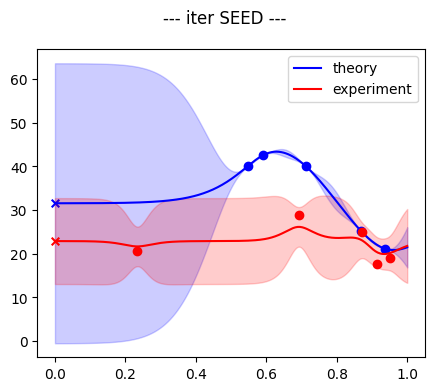

In [ ]:
figs[0]


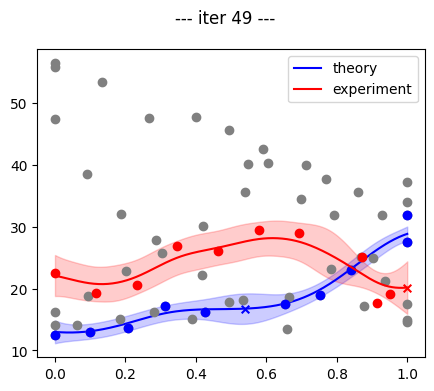

In [ ]:
figs[50]

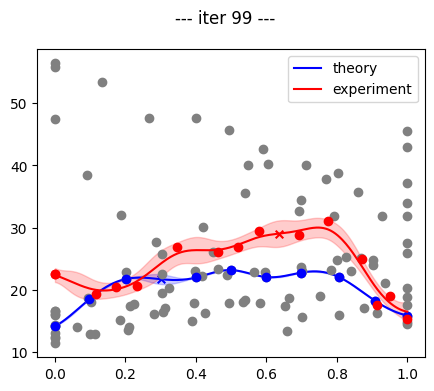

In [ ]:
figs[100]

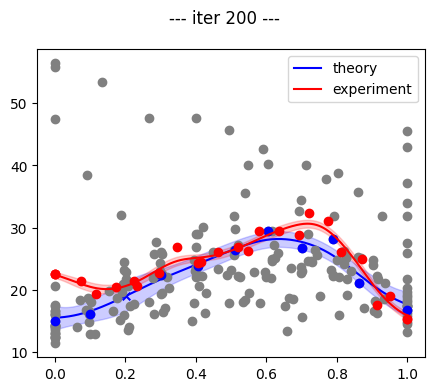

In [ ]:
figs[-1]

In [ ]:
coord_adj[np.argmax(-mean + var**0.5)]

array([0.04, 0.09, 0.03])

In [ ]:
mse_calculation(X_train_exp, y_train_exp, gp_exp)

NameError: name 'gp_exp' is not defined

In [ ]:
res_dict['params'] = sputtering_params

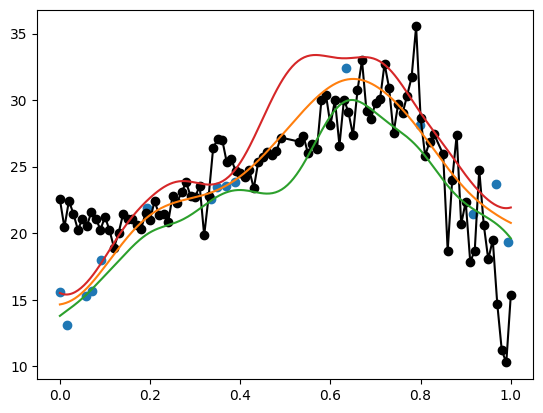

In [ ]:
plt.plot(X_train_th, y_train_th, 'o')
plt.plot(*roughness_array.T, 'ko-', )
plt.plot(X, th_mean)
plt.plot(X, th_mean-th_var)
plt.plot(X, th_mean+th_var)

In [ ]:
sputtering_params

{'film': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'dE': {('A', 'A'): tensor(0.0400, dtype=torch.float64),
  ('A', 'B'): tensor(0.0900, dtype=torch.float64),
  ('B', 'B'): tensor(0.0500, dtype=torch.float64)},
 'atoms': ['A', 'B'],
 't': 100,
 'n_hops': 3,
 'dist': 2,
 'E0': 0.2,
 'k_up': 0.15,
 'k_down': 0.1,
 'T': 700,
 'flow': tensor([17.7258, 82.2742], dtype=torch.float64)}